In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
# import jax.numpy as np
from scipy.signal import freqz
from scipy.signal import butter, lfilter
import scipy.signal as signal
import time
from matplotlib.backend_bases import MouseButton
from libusb_reader_ft601 import read_data, check_ramp
from plotting_utils import plot_fft_bodes
# ipympl
%matplotlib widget

fs = 60000000 #Samples / Second

# Reading data from Streamoscope
This section reads data from the Streamoscope. The old data in the buffer is dumped out, and then it listens for data and reads until there is either a data limit reached or the Streamoscope stops sending data. The data is then optionally written into a pickle file.

In [26]:
#Whether or not to read out old data and throw it away. This is useful for when the Streamoscope's buffer has old samples in it
dump_data = True 

#Max number of samples to dump. This is not a hard limit and it may go over by up to 10k samples
dump_sample_limit = 32e7

#Time limit for dumping data in seconds
dump_time_limit = 0.5 #seconds

#How many seconds of data to capture. This is approximate since it can overshoot up to 10k samples, or 167us
capture_time = 50e-3 #seconds, approximate. 1 spin echo is about 4 ms long
sample_limit = capture_time * fs #868836*3

#Whether or not to pickle the acquistion to save for later
pickle_data = True

#The filename for pickled data. If None, a name is automatically generated
pickle_filename = None

print("Rough sample limit:",sample_limit)

if dump_data: read_data(sample_limit=dump_sample_limit, wait_for_data=False, quiet=True, print_listening=False, exit_on_no_data=True, read_timeout=dump_time_limit)

ch_0, ch_1, flag_0, flag_1, flag_2, flag_3, filename = read_data(sample_limit=sample_limit, wait_for_data=True, quiet=True, print_listening=True, pickle_data=pickle_data, filename=pickle_filename)

Rough sample limit: 3000000.0
listening...
Found data!
Pickling...
Pickled into streamoscope_data_20240823_153522.pkl


# Reading data from Pickle
This section reads in data from a pickle file previously captured with the Streamoscope

In [3]:
filename = 'streamoscope_data_20240822_182202.pkl'


In [4]:
pkl_file = open(filename, 'rb')

ch_0 = pickle.load(pkl_file)
ch_1 = pickle.load(pkl_file)
flag_0 = pickle.load(pkl_file)
flag_1 = pickle.load(pkl_file)
flag_2 = pickle.load(pkl_file)
flag_3 = pickle.load(pkl_file)

pkl_file.close()

# Taking FFT of Spin Echo
For a usage example, we will display a single spin echo, select the bounds of the spin echo, and take the fourier transform to see its bandwidth. First we plot the data 

## Selecting bounds
First we plot the data by detecting the first RF pulse and zooming in on it for ```x_extent``` samples. Right click to first select the start point of the spin echo and right click to select the end point. Right clicking again is the start for a new spin echo which will be plotted in the final FFT as well

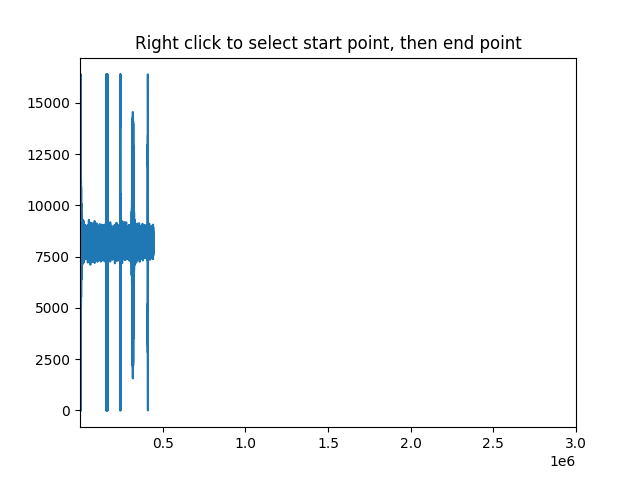

In [27]:
plt.figure()
plt.title("Right click to select start point, then end point")


coords = []

color_options = ['green','red']
color_ind = 0

current_click = ['start']

def on_move(event):
    if event.inaxes:
        print(f'data coords {event.xdata} {event.ydata},',
              f'pixel coords {event.x} {event.y}',
              f'chosen coords {coords}')


def on_click(event):
    if event.button is MouseButton.RIGHT and event.inaxes:
        # print('disconnecting callback')
        # plt.disconnect(binding_id)
        if current_click[0] == 'start':
            coords.append([event.xdata])
            current_click[0] = 'end'
            plt.axvline(x = event.xdata, color='green')
        else: #end
            coords[-1].append(event.xdata)
            current_click[0] = 'start'
            plt.axvline(x = event.xdata, color='red')
        
        


binding_id = plt.connect('motion_notify_event', on_move)
plt.connect('button_press_event', on_click)


display_only_triggers = True
x_extent = 50e-3*fs

data_to_display = ch_0[flag_3] if display_only_triggers else ch_0

#default zoom to first RF event
x_start = np.argmax(data_to_display > 2**14-10)

plt.xlim(x_start, x_start+x_extent)
plt.plot(data_to_display)
plt.show()

## Plotting FFT
Then we plot each of the selected signals along with a line at -6dB from their max point to see the bandwidth

In [6]:
coords

[[125844.45161290324, 198425.09677419357],
 [388344.45161290327, 454876.70967741933]]

In [28]:
signals = [data_to_display[int(i):int(j)] for i, j in coords]

27382201.19769226
0.0 0


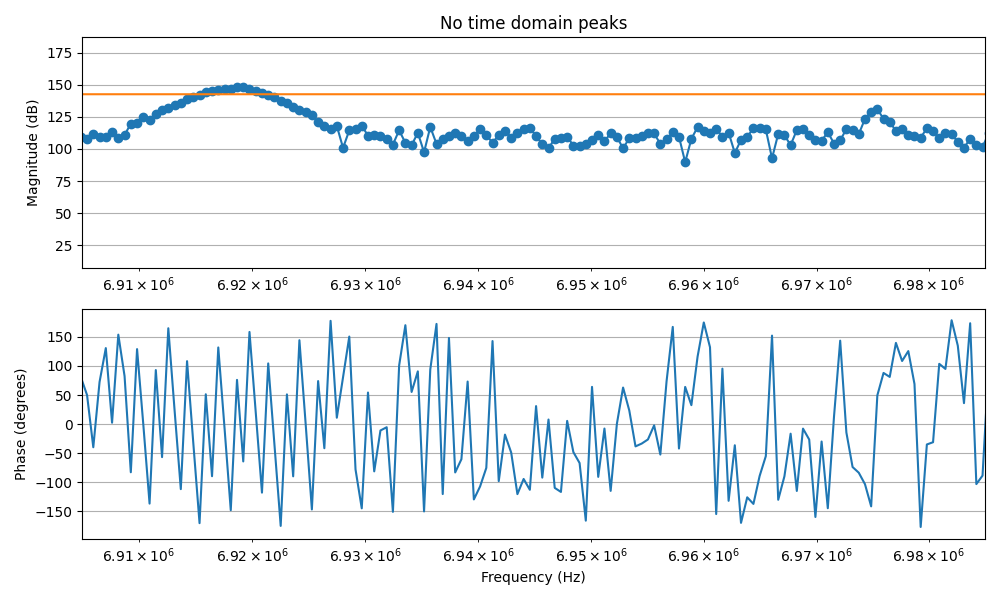

In [29]:
plot_fft_bodes(signals, fs, True, title="No time domain peaks", center=6.945e6, bandwidth=80e3)

# Using FT601 GPIO

In [25]:
from array import array
import ctypes
import usb.core
import usb.backend.libusb1
import time

#get handle on FT601

dev = usb.core.find(idVendor = 0x0403, idProduct=0x601f)

print('dev',dev)
print('dev[0].interfaces()',dev[0].interfaces())

ep = dev[0].interfaces()[0].endpoints()[0]
print('ep',ep)

i = dev[0].interfaces()[1].bInterfaceNumber
print('i',i)

dev.reset()

config = array('B', [0x00, 0x00, 0x00, 0x00, 0x82, 0x02, 0x00, 0x00, 0x00, 0x00, 0x00, 0x40, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,0x00])

SIZE = 1280000  #*8
data = array('L', list(SIZE*[1]))
print(data.itemsize)

r = ep.write(config)
print(r)
time.sleep(0.5)



dev DEVICE ID 0403:601f on Bus 001 Address 005 =================
 bLength                :   0x12 (18 bytes)
 bDescriptorType        :    0x1 Device
 bcdUSB                 :  0x310 USB 3.1
 bDeviceClass           :   0xef Miscellaneous
 bDeviceSubClass        :    0x2
 bDeviceProtocol        :    0x1
 bMaxPacketSize0        :    0x9 (9 bytes)
 idVendor               : 0x0403
 idProduct              : 0x601f
 bcdDevice              :    0x0 Device 0.0
 iManufacturer          :    0x1 FTDI
 iProduct               :    0x2 FTDI SuperSpeed-FIFO Bridge
 iSerialNumber          :    0x3 000000000001
 bNumConfigurations     :    0x1
  CONFIGURATION 1: 24 mA ===================================
   bLength              :    0x9 (9 bytes)
   bDescriptorType      :    0x2 Configuration
   wTotalLength         :   0x57 (87 bytes)
   bNumInterfaces       :    0x2
   bConfigurationValue  :    0x1
   iConfiguration       :    0x0 
   bmAttributes         :   0xe0 Self Powered, Remote Wakeup
   bMaxPow

In [ ]:


'''
// configure both gpio as outputs
void set_gpio(libusb_device_handle* usb_handle){
    // configure both gpio as outputs
    unsigned char enable_gpio[] = {0x2d, 0x00};
    libusb_control_transfer(usb_handle, 0x40, 02, 0002, 0000, enable_gpio, 0002, 500);
    libusb_control_transfer(usb_handle, 0x40, 02, 0001, 0000, enable_gpio, 0002, 500);
    // set GPIO to 0
    unsigned char set_gpio[] = {0x24, 0x00};
    libusb_control_transfer(usb_handle, 0x40, 02, 0001, 0000, set_gpio, 0002, 500);
    // assert gpio 0
    sleep(1);
    set_gpio[0] |= 1;
    libusb_control_transfer(usb_handle, 0x40, 02, 0001, 0000, set_gpio, 0002, 500); // assert gpio 1
    sleep(1);
    set_gpio[0] |= 8;
    libusb_control_transfer(usb_handle, 0x40, 02, 0001, 0000, set_gpio, 0002, 500);
}
'''

'''
int libusb_control_transfer 	( 	libusb_device_handle *  	dev_handle,
		uint8_t  	bmRequestType,
		uint8_t  	bRequest,
		uint16_t  	wValue,
		uint16_t  	wIndex,
		unsigned char *  	data,
		uint16_t  	wLength,
		unsigned int  	timeout 
	) 	
'''

enable_gpio = array('B', [0x2d, 0x00])
gpio_config_1 = array('B', [02, 0002, 0000, enable_gpio, 0002, 500])
gpio_config_2 = array('B', [02, 0002, 0000, enable_gpio, 0002, 500])
dev.write(0x40, gpio_config_1)

